In [1]:
import numpy as np
import math
from dataclasses import dataclass
from sympy import Matrix, sqrt
from random import randint
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigs

# We follow Szabo and Ostlund page 146 for the SCF procedure.

@dataclass
class Coordinate:
    x1: float
    x2: float
    x3: float


def to_basis_element_index(i, j, k, K):
    """
    Converts grid location (i, j, k) to a basis index i K^2 + j K + k.
    :param i: The index of the position in x1.
    :param j: The index of the position in x2.
    :param k: The index of the position in x3.
    :param K: The number of divisions of x1, x2 and x3.
    :return: The index of the corresponding product delta function in the finite basis list.
    """
    return i * K ** 2 + j * K + k


def from_basis_element_index(n, K):
    """
    Converts a basis index n to a location (i, j, k).
    :param n: The basis index.
    :param K: The divisions of x1, x2 and x3.
    :return: The location i, j, k.
    """
    i = math.floor(n / (K ** 2))
    j = math.floor((n % (K ** 2)) / K)
    k = (n % (K ** 2)) % K
    return i, j, k


def get_element_kinetic_part(n, m):
    """
    Returns the matrix element at col m and row n of H_kinetic.
    :param n: The row.
    :param m: The column.
    :return: The corresponding matrix element.
    """

    if (n == m):
        return 3 / delta ** 2
    elif (m == n - 1) or (m == n + 1) or (m == n - K) \
            or (m == n + K) or (m == n - K ** 2) or (m == n + K ** 2):
        return -1 / (2 * delta ** 2)
    else:
        return 0


def get_element_nuclear_attraction(n, m, nuclear_coordinates, atom_nums):
    """
    Returns the matrix element at col m and row n of H_nuclear_attraction.
    :param n: The row.
    :param m: The column.
    :param nuclear_coordinates: The coordinates of our nuclei.
    :param atom_nums: The atomic numbers.
    :return: The corresponding matrix element.
    """
    assert len(atom_nums) == len(nuclear_coordinates)

    if n == m:
        i, j, k = from_basis_element_index(n, K)

        attractions = 0
        for c, coord in enumerate(nuclear_coordinates):
            attractions -= atom_nums[c] / abs(sqrt((i * delta - coord.x1) ** 2 +
                                                   (j * delta - coord.x2) ** 2 +
                                                   (k * delta - coord.x3) ** 2))

        return attractions

    else:
        return 0


def get_element_coulomb_term(n, m, K, psi, delta):
    """
    Calculates the Coulomb term.
    :param n: The row.
    :param m: The column
    :param K: The number of divisions.
    :param psi: The wavefunction.
    :param delta: The grid spacing.
    :return: The Coulomb term.
    """

    if n == m:

        sum = 0
        i, j, k = from_basis_element_index(n, K)

        for p in range(K ** 3):
            r, s, t = from_basis_element_index(p, K)

            sum += delta ** 3 * psi[n].conjugate() \
                   * (1 / abs(sqrt((i * delta - r * delta) ** 2 +
                                   (j * delta - s * delta) ** 2 +
                                   (k * delta - t * delta) ** 2))) * psi[n]

        return sum
    else:
        return 0


def get_element_exchange_term(n, m, K, psi, delta):
    """
    Calculates an element of the exchange term.
    :param n: The row.
    :param m: The column.
    :param K: The number of divisions.
    :param psi: The wavefunction.
    :param delta: The size of the divisions.
    :return: The exchange term element.
    """
    sum = 0
    i, j, k = from_basis_element_index(n, K)
    r, s, t = from_basis_element_index(m, K)

    return delta ** 3 * psi[m].conjugate() \
           * (1 / abs(sqrt((i * delta - r * delta) ** 2 +
                           (j * delta - s * delta) ** 2 +
                           (k * delta - t * delta) ** 2))) * psi[n]


def get_charge_density_bond_order_matrix_element(n, m, electrons, coeffs):
    """
    Constructs a charge density bond order matrix. See Szabo and Ostlund page 139.
    :param electrons: Number of electrons.
    :param coeffs: The coefficients for each electron (column) and basis function (row).
    :return: The matrix.
    """
    sum = 0
    for a in range(math.floor(electrons / 2)):
        sum += coeffs[n][a] * coeffs[m][a].conjugate()

    sum = 2 * sum

    return sum


def clean_zoos(M):
    """
    Remove complex infinities.
    :param M: The matrix to clean.
    :return: The cleaned matrix.
    """
    for r in range(len(M.row(0))):
        for c in range(len(M.row(0))):
            if 'zoo' in str(M[r, c]):
                M[r, c] = 10000
            elif 'nan' in str(M[r, c]):
                M[r, c] = 0

    return M

In [2]:
# H2 molecule

nuclear_coordinates = [Coordinate(0, 0, 0), Coordinate(0, 0, 0.74)]
atomic_numbers = [1, 1]
num_electrons = 2

size = 10  # size of space
K = 10  # number of divisions
delta = size / K  # division size



In [3]:
# We use symmetric orthogonalization per Szabo and Ostlund page 143.

S = np.diag([1 for i in range(K ** 3)]).astype(float)  # We know our basis is diagonal.

eigen_values, eigen_vectors = eigs(S, which="SM", k=6)
s_diag = np.diag(eigen_values ** -0.5)
ortho_matrix = np.dot(eigen_vectors, np.dot(s_diag, np.transpose(eigen_vectors)))


In [5]:
# We construct the core Hamiltonian.

kinetic = Matrix([[get_element_kinetic_part(row, col)
                   for col in range(K ** 3)] for row in range(K ** 3)])

print(kinetic)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [7]:
nuclear_attraction = Matrix(
    [[get_element_nuclear_attraction(row, col, nuclear_coordinates, atomic_numbers)
       for col in range(K ** 3)] for row in range(K ** 3)])

H_core = kinetic + nuclear_attraction

H_core = clean_zoos(H_core)

print(H_core)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [9]:
# Now we solve for our two-electron integrals.

# Our initial guess is a poor one.

psi = [randint(0, 10) * 0.1 for o in range(K ** 3)]

# Construct the Coulomb matrix.

C = Matrix([[get_element_coulomb_term(row, col, K, psi, delta) * 2
             for col in range(K ** 3)] for row in range(K ** 3)])

print(C)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [14]:
# Construct the Exchange matrix.

E = Matrix([[get_element_exchange_term(row, col, K, psi, delta)
             for col in range(K ** 3)] for row in range(K ** 3)])

G = C + E

G = clean_zoos(G)

print(G)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [15]:
# Construct and transform the Fock matrix.

F = H_core + G

F_trans = np.matmul(np.matmul(np.transpose(np.conjugate(ortho_matrix)),
                              np.array(F).astype(np.float64)), ortho_matrix)

print(F_trans)

[[ 5.86263730e-03+0.j  6.59134389e-06+0.j -3.58633843e-03+0.j ...
  -1.96967744e-03+0.j  9.97439057e-04+0.j  3.00812938e-03+0.j]
 [ 6.59134389e-06+0.j  1.79010616e-08+0.j -8.28172092e-06+0.j ...
  -5.58691291e-06+0.j  1.54160670e-06+0.j  2.91153119e-06+0.j]
 [-3.58633843e-03+0.j -8.28172092e-06+0.j  2.19242987e-02+0.j ...
   5.36303624e-03+0.j -1.10268433e-03+0.j -8.47309702e-04+0.j]
 ...
 [-1.96967744e-03+0.j -5.58691291e-06+0.j  5.36303624e-03+0.j ...
   3.36382373e-03+0.j -1.09089350e-03+0.j -1.57766178e-04+0.j]
 [ 9.97439057e-04+0.j  1.54160670e-06+0.j -1.10268433e-03+0.j ...
  -1.09089350e-03+0.j  2.87789733e-03+0.j -4.31740211e-04+0.j]
 [ 3.00812938e-03+0.j  2.91153119e-06+0.j -8.47309702e-04+0.j ...
  -1.57766178e-04+0.j -4.31740211e-04+0.j  2.08828209e-03+0.j]]


In [16]:
# Get an updated guess from the transformed Fock matrix's eigen vectors.

eigen_values, eigen_vectors = np.linalg.eig(F_trans)
g = np.dot(ortho_matrix, eigen_vectors)

new_psi = g[0]


print(g)

[[-2.55177418e-02-2.56162428e-38j -1.70684415e-03-2.88829066e-37j
  -1.77255790e-04+3.83609389e-36j ...  4.06575815e-20-1.11875597e-19j
   3.38813179e-20+1.88923613e-20j  2.71050543e-20-4.48119887e-20j]
 [-2.98529963e-05-9.25479654e-41j -9.98228065e-06-6.66179774e-39j
  -1.97552844e-05+1.50317550e-37j ...  1.98523347e-22-6.95899689e-22j
   9.66146955e-22-9.80212309e-24j  7.74241053e-22-3.45517926e-22j]
 [ 1.51206997e-02-1.32705965e-37j -3.00789148e-02+6.84706508e-36j
   7.16599591e-02-3.46922510e-34j ...  7.87740641e-19+1.16545510e-18j
  -1.48654282e-18-8.63372822e-20j -2.10064171e-19+1.71750674e-19j]
 ...
 [ 6.21404785e-03+4.27322281e-38j  9.25175303e-03+4.35991973e-37j
   2.20943580e-02-1.03693852e-34j ...  2.60886148e-19+4.00246550e-19j
  -3.28648784e-19-9.41927705e-20j -3.04931861e-20+1.04311940e-19j]
 [-9.90999991e-04-1.17293099e-37j -2.65674130e-02+1.69143163e-36j
  -9.93054291e-03+5.38296614e-35j ... -4.60785923e-19-4.21361318e-20j
   2.30392962e-19+4.44969272e-20j -5.33630757e-

In [ ]:
# Convergence criteria.

inner_tolerance = 0.1
outer_tolerance = 0.5
converged = False

while not converged:

    old_eigen_values = eigen_values
    old_psi = new_psi

    # Construct the Coulomb matrix.

    C = Matrix(
        [[get_element_coulomb_term(row, col, K, new_psi, delta) * 2
          for col in range(K ** 3)] for row in range(K ** 3)])

    # Construct the Exchange matrix.

    E = Matrix([[get_element_exchange_term(row, col, K, new_psi, delta)
                 for col in range(K ** 3)] for row in range(K ** 3)])

    G = C + E

    G = clean_zoos(G)

    # Construct and transform the Fock matrix.

    F = H_core + G

    F_trans = np.matmul(np.matmul(np.transpose(np.conjugate(ortho_matrix)),
                                  np.array(F).astype(np.float64)), ortho_matrix)

    # Get an updated guess from the transformed Fock matrix's eigen vectors.

    eigen_values, eigen_vectors = np.linalg.eig(F_trans)
    g = np.dot(ortho_matrix, eigen_vectors)

    new_psi = g[0]

    # Test for convergence using the energy of the system (the eigenvalues).

    converged = (np.sum(eigen_values - old_eigen_values < inner_tolerance)
                 / eigen_values.size) > outer_tolerance


In [11]:
eigen_values, eigen_vectors = np.linalg.eig(np.array(F).astype(np.float64))

print("Energies:")
print(eigen_values)

Energies:
[ 1.00004557e+04 -1.79843357e+02 -6.33891226e+01 -1.16483345e+00
 -6.43851111e-01 -7.39299566e-01 -8.59739039e-01 -9.04521744e-01]


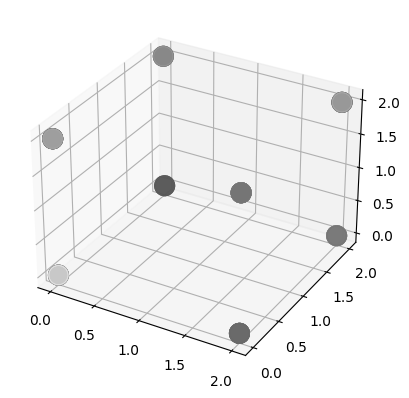

In [15]:
# Plotting.

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

xs = []
ys = []
zs = []
cs = []

for vec in eigen_vectors:
    for n in range(len(vec)):
        i, j, k = from_basis_element_index(n, K)
        xs.append(i * delta)
        ys.append(j * delta)
        zs.append(k * delta)
        cs.append(vec[n])

ax.scatter(xs, ys, zs, c=cs, cmap='gray')

plt.show()
